In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import LFCNNWInterpreter
import random
import torch.nn as nn
from deepmeg.experimental.models import LFCNNW

/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_activations(
    event_names, roi_labels, n_rois=1
):
    start = 0
    random.shuffle(roi_labels)
    activations = dict()

    for event in event_names:
        n_rois_sel = int(np.random.randint(1, n_rois+1))
        sel_rois = roi_labels[start:start+n_rois_sel]
        activations[event] = [(sel_roi.name, int(np.random.randint(10, 100))) for sel_roi in sel_rois]
        start += n_rois_sel

        if start >= len(roi_labels):
            break

    return activations


def plot_roi(roi_labels, subject, subjects_dir, colors=None, marker_sizes=None):
    coords = list()
    for roi_label in roi_labels:
        if roi_label.name[-2:] == 'lh':
            hemi = 0
        elif roi_label.name[-2:] == 'rh':
            hemi = 1
        else: raise ValueError(f'Hemisphere undefined: {roi_label.name}')

        coords.append(
            mne.vertex_to_mni(
                roi_label.center_of_mass(
                    subject,
                    subjects_dir=subjects_dir
                ),
                hemi,
                subject,
                subjects_dir=subjects_dir
            )
        )
    if isinstance(colors, str):
        colors = [colors for _ in coords]
    view = plotting.view_markers(
        coords, colors,
        marker_size=marker_sizes
    )
    return view


def data_fun(times, latency, duration, rng=None, f = 15):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    if not rng:
        rng = np.random.RandomState(7)
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf


# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
from collections import namedtuple

EventConfig = namedtuple('EventConfig', 'start duration id')


def create_events(*configs: EventConfig, duration, sfreq):
    n_points = int(duration*sfreq)
    all_events = list()
    for config in configs:
        currect_timepoint = int(config.start*sfreq)
        events = list()
        while currect_timepoint < n_points:
            events.append([currect_timepoint, 0, config.id])
            currect_timepoint += int(config.duration*sfreq)
        all_events += events
    all_events = np.array(all_events)
    return all_events[np.argsort(all_events[:, 0])]


In [4]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_info = meg_path / 'sample_audvis_raw.fif'
info_orig = mne.io.read_raw_fif(fname_info).resample(200).info#read_info(fname_info)
tstep = 1 / info_orig['sfreq']
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

events = mne.read_events(fname_event)

# events = create_events(
#     EventConfig(10., 3., 1),
#     EventConfig(11., 3., 2),
#     EventConfig(12, 3., 3),
#     duration=300,
#     sfreq=info_orig['sfreq']
# )

noise_cov = mne.read_cov(fname_cov)

# event_id = {'e1': 1, 'e2': 2, 'e3': 3,
#             'e4': 4, 'e5': 5, 'e6': 32}
event_id = {'e1': 1, 'e2': 2, 'e3': 3, 'e4': 4}

all_labels = mne.read_labels_from_annot('sample', parc='aparc.a2009s', subjects_dir=subjects_dir)
label_by_name = {label.name: label for label in all_labels}


In [5]:
list(label_by_name.keys())

['G_Ins_lg_and_S_cent_ins-lh',
 'G_Ins_lg_and_S_cent_ins-rh',
 'G_and_S_cingul-Ant-lh',
 'G_and_S_cingul-Ant-rh',
 'G_and_S_cingul-Mid-Ant-lh',
 'G_and_S_cingul-Mid-Ant-rh',
 'G_and_S_cingul-Mid-Post-lh',
 'G_and_S_cingul-Mid-Post-rh',
 'G_and_S_frontomargin-lh',
 'G_and_S_frontomargin-rh',
 'G_and_S_occipital_inf-lh',
 'G_and_S_occipital_inf-rh',
 'G_and_S_paracentral-lh',
 'G_and_S_paracentral-rh',
 'G_and_S_subcentral-lh',
 'G_and_S_subcentral-rh',
 'G_and_S_transv_frontopol-lh',
 'G_and_S_transv_frontopol-rh',
 'G_cingul-Post-dorsal-lh',
 'G_cingul-Post-dorsal-rh',
 'G_cingul-Post-ventral-lh',
 'G_cingul-Post-ventral-rh',
 'G_cuneus-lh',
 'G_cuneus-rh',
 'G_front_inf-Opercular-lh',
 'G_front_inf-Opercular-rh',
 'G_front_inf-Orbital-lh',
 'G_front_inf-Orbital-rh',
 'G_front_inf-Triangul-lh',
 'G_front_inf-Triangul-rh',
 'G_front_middle-lh',
 'G_front_middle-rh',
 'G_front_sup-lh',
 'G_front_sup-rh',
 'G_insular_short-lh',
 'G_insular_short-rh',
 'G_oc-temp_lat-fusifor-lh',
 'G_oc-te

In [6]:
activations = {
    'e1': [
        ('S_interm_prim-Jensen-rh', 5),
        # ('S_oc-temp_lat-rh', 5),
        ('S_oc-temp_med_and_Lingual-rh', 20),
        # ('S_intrapariet_and_P_trans-rh', 5),
        # ('S_oc_middle_and_Lunatus-rh', 5),
        # ('G_temporal_middle-rh', 5),
    ],
    'e2': [
        # ('S_circular_insula_inf-rh', 5),
        # ('S_interm_prim-Jensen-rh', 5),
        ('S_oc-temp_lat-lh', 20),
        # ('S_oc-temp_med_and_Lingual-rh', 20),
        ('G_temporal_middle-lh', 5),
    ],
    'e3': [
        ( 'G_front_inf-Triangul-lh', 20),
        ( 'G_front_inf-Triangul-rh', 20),
        # ('S_collat_transv_post-rh', 8)
        # ('G_orbital-rh', 70)
    ],
    'e4': [('S_parieto_occipital-lh', 30), ('S_parieto_occipital-rh', 30)],
    # 'e5': [('G_front_inf-Opercular-rh', 22), ('S_circular_insula_sup-lh', 23)],
    # 'e6': [('S_circular_insula_sup-rh', 58), ('G_cuneus-lh', 23)]
}

In [7]:
all_activations = activations
labels = list()
marker_sizes = list()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
all_colors = list()
for color, (event_name, activation) in zip(colors, all_activations.items()):
    for a in activation:
        labels.append(label_by_name[a[0]])
        marker_sizes.append(a[1])
        all_colors.append(color)

plot_roi(labels, 'sample', subjects_dir, all_colors, marker_sizes)

In [8]:
activations


{'e1': [('S_interm_prim-Jensen-rh', 5), ('S_oc-temp_med_and_Lingual-rh', 20)],
 'e2': [('S_oc-temp_lat-lh', 20), ('G_temporal_middle-lh', 5)],
 'e3': [('G_front_inf-Triangul-lh', 20), ('G_front_inf-Triangul-rh', 20)],
 'e4': [('S_parieto_occipital-lh', 30), ('S_parieto_occipital-rh', 30)]}

In [9]:
# all_activations = dict(**activations, **new_activations)
all_activations = activations

In [10]:
annot = 'aparc.a2009s'
label_names = sorted(set(activation[0]
                         for activation_list in all_activations.values()
                         for activation in activation_list))
region_names = list(all_activations.keys())

In [11]:
info_orig['sfreq']

200.0

In [12]:
times = np.arange(600, dtype=np.float64) / info_orig['sfreq']
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

durations = [0.05, 0.08, 0.1, .15]
latencies = [0.1, 0.5, 0.8, .6]
freqs = [10., 20., 60., 70.]

cfg_data = dict()

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(len(all_activations[region_name])):
        label_name = all_activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = all_activations[region_name][i][1]

        if region_name in activations.keys():
            # duration = np.random.uniform(0.01, 0.1)
            duration = durations[region_id-1]
            # latency_tmp = np.random.uniform(0.1, 0.6)
            latency_tmp = latencies[region_id-1]
            # f = np.random.uniform(8., 30.)
            f = freqs[region_id-1]
        else:
            duration = np.random.uniform(0.01, 0.5)
            latency_tmp = np.random.uniform(0.1, 1.6)
            f = np.random.uniform(8., 30.)
        if region_name not in cfg_data:
            cfg_data[region_name] = dict()
        cfg_data[region_name][label_name] = dict(duration=duration, latency=latency_tmp, frequency=f)
        # f = freqs[region_id-1]
        wf_tmp = data_fun(times, latency_tmp, duration, f=f)
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * wf_tmp,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

In [13]:
for event, eventdict in cfg_data.items():
    print(f'{event}:')
    for region, regiondict in eventdict.items():
        print(f'\t{region}:')
        for param, value in regiondict.items():
            print(f'\t\t{param}: {value}')

e1:
	S_interm_prim-Jensen-rh:
		duration: 0.05
		latency: 0.1
		frequency: 10.0
	S_oc-temp_med_and_Lingual-rh:
		duration: 0.05
		latency: 0.1
		frequency: 10.0
e2:
	S_oc-temp_lat-lh:
		duration: 0.08
		latency: 0.5
		frequency: 20.0
	G_temporal_middle-lh:
		duration: 0.08
		latency: 0.5
		frequency: 20.0
e3:
	G_front_inf-Triangul-lh:
		duration: 0.1
		latency: 0.8
		frequency: 60.0
	G_front_inf-Triangul-rh:
		duration: 0.1
		latency: 0.8
		frequency: 60.0
e4:
	S_parieto_occipital-lh:
		duration: 0.15
		latency: 0.6
		frequency: 70.0
	S_parieto_occipital-rh:
		duration: 0.15
		latency: 0.6
		frequency: 70.0


In [14]:
raw_sim = mne.simulation.simulate_raw(info_orig, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(
    raw_sim,
    cov=noise_cov,
    random_state=0
)
# mne.simulation.add_eog(raw_sim, random_state=0)
# mne.simulation.add_ecg(raw_sim, random_state=0)

# Plot original and simulated raw data.
# %matplotlib inline
# fig = raw_sim.plot(title='Simulated raw data')

<RawArray | 376 x 155086 (775.4 s), ~448.2 MB, data loaded>

In [15]:
event_id = {'e1': 1, 'e2': 2, 'e3': 3, 'e4': 4}

In [44]:
epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=2.,
                    baseline=(None, 0), event_repeated='drop')
epochs.load_data().resample(200).crop(0., None).pick_types(meg='grad')
epochsoi = epochs[['e1', 'e2', 'e3', 'e4']]
evo = epochsoi.average(by_event_type=True)

/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


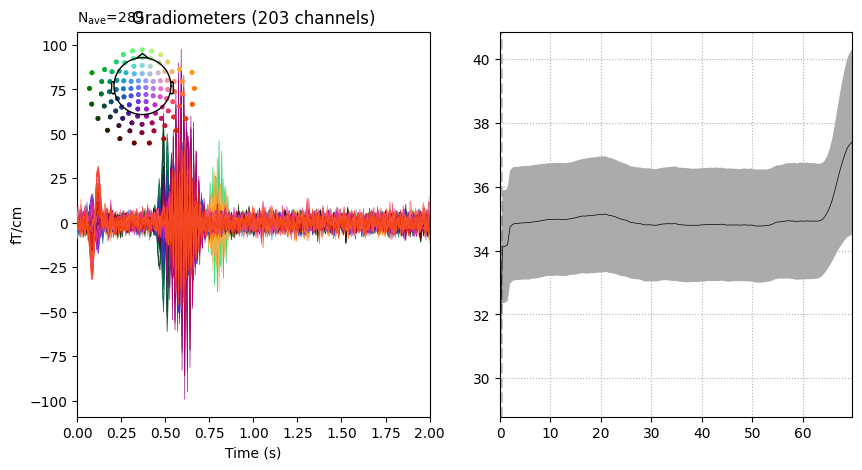

In [45]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochsoi.plot_psd(average=True, ax=ax2, fmax=70)
epochsoi.average().plot(axes=ax1)
plt.show()

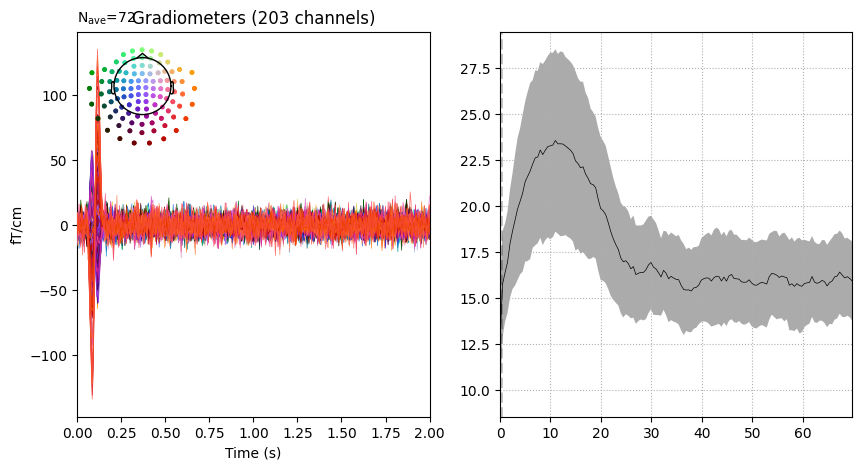

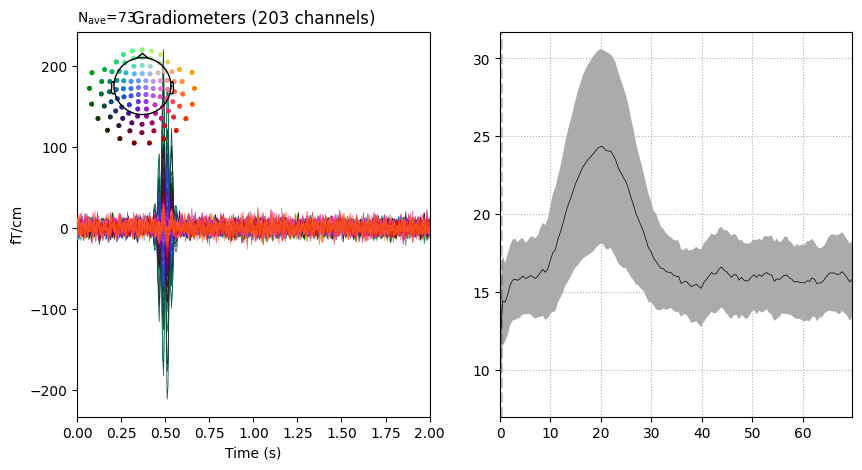

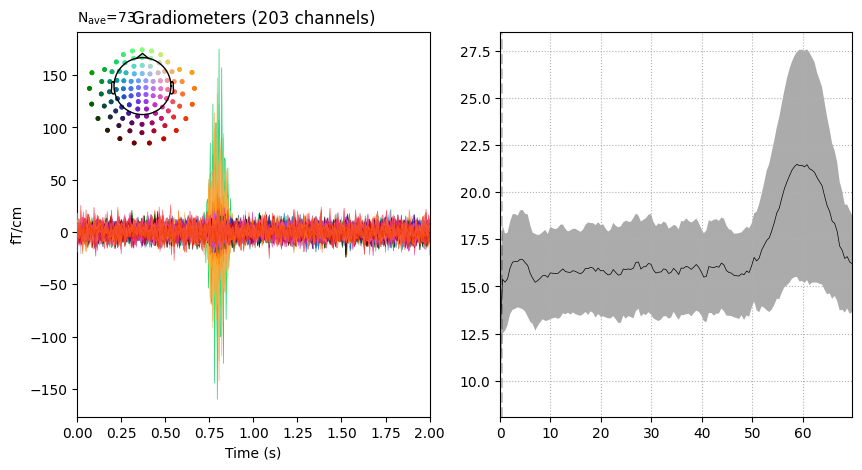

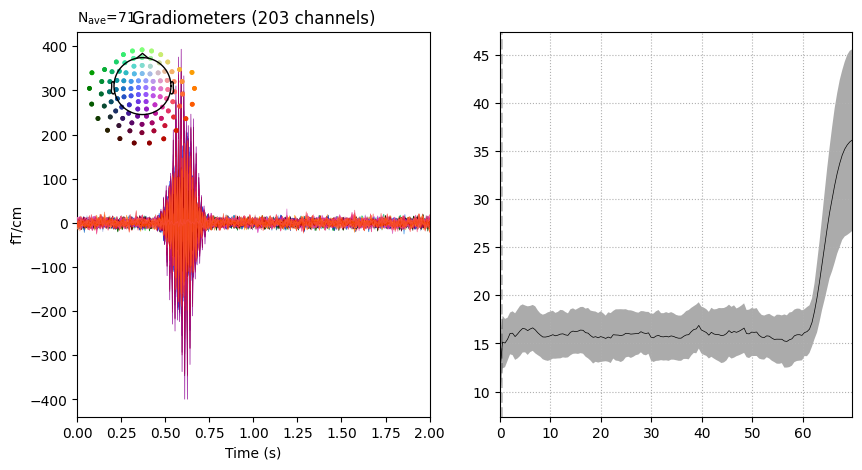

In [46]:
for evoked in evo:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    evoked.plot_psd(average=True, ax=ax2, fmax=70)
    evoked.plot(axes=ax1)
    plt.show()

In [48]:
dataset = EpochsDataset(
    (
        epochsoi
        # data,
        # one_hot_encoder(labels)
    ),
    savepath='../datasets/simulated',
    transform=zscore
)

In [49]:
dataset.save('../data/simulated.pt')

In [4]:
dataset = read_epochs_dataset('../data/simulated.pt')

In [50]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [51]:
X, y = next(iter(DataLoader(test, len(test))))
X.shape

torch.Size([86, 203, 401])

In [28]:
# from mne.datasets import multimodal
# fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(200).pick_types(meg='grad').info

In [61]:
kwargs = dict(
    n_channels=X.shape[1],
    n_times=X.shape[-1],
    n_latent=8,
    filter_size=50,
    pool_factor=1,
    n_outputs=y.shape[-1]
)

In [62]:
from deepmeg.models.interpretable import LFCNN

# model = TSNet(**lfcnn_kwargs)

model = LFCNNW(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [33]:
sys.stdout = sys.stdout.file

AttributeError: 'OutStream' object has no attribute 'file'

Epoch 0:  loss_train:  0.7278   |    binary_accuracy_train:  0.3822   |    loss_val:  0.7239   |    binary_accuracy_val:  0.6467
Epoch 1:  loss_train:  0.7237   |    binary_accuracy_train:  0.6863   |    loss_val:  0.7199   |    binary_accuracy_val:  0.7500
Epoch 2:  loss_train:  0.7196   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7157   |    binary_accuracy_val:  0.7500
Epoch 3:  loss_train:  0.7154   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7114   |    binary_accuracy_val:  0.7500
Epoch 4:  loss_train:  0.7109   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7067   |    binary_accuracy_val:  0.7500
Epoch 5:  loss_train:  0.7061   |    binary_accuracy_train:  0.7500   |    loss_val:  0.7015   |    binary_accuracy_val:  0.7500
Epoch 6:  loss_train:  0.7009   |    binary_accuracy_train:  0.7500   |    loss_val:  0.6960   |    binary_accuracy_val:  0.7500
Epoch 7:  loss_train:  0.6953   |    binary_accuracy_train:  0.7500   |    loss_val:  0.6900   | 

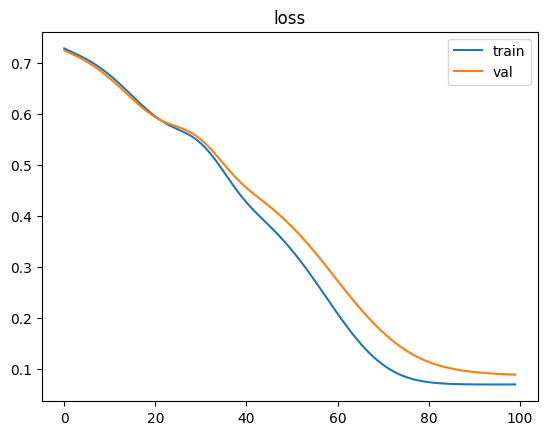

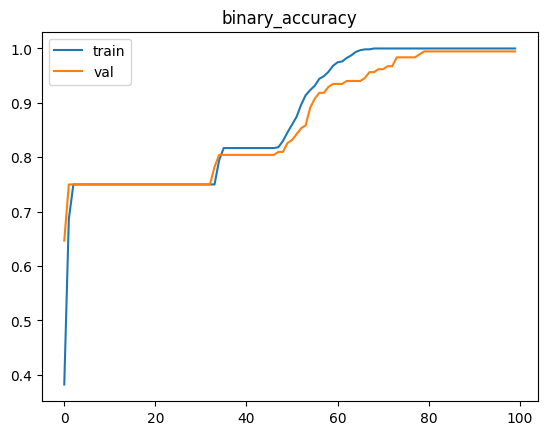

In [63]:
history = model.fit(train, n_epochs=100, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [58]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.20759194547479803
train_binary_accuracy: 0.9704545519568704
loss: 0.2786341526291587
binary_accuracy: 0.9261363636363636


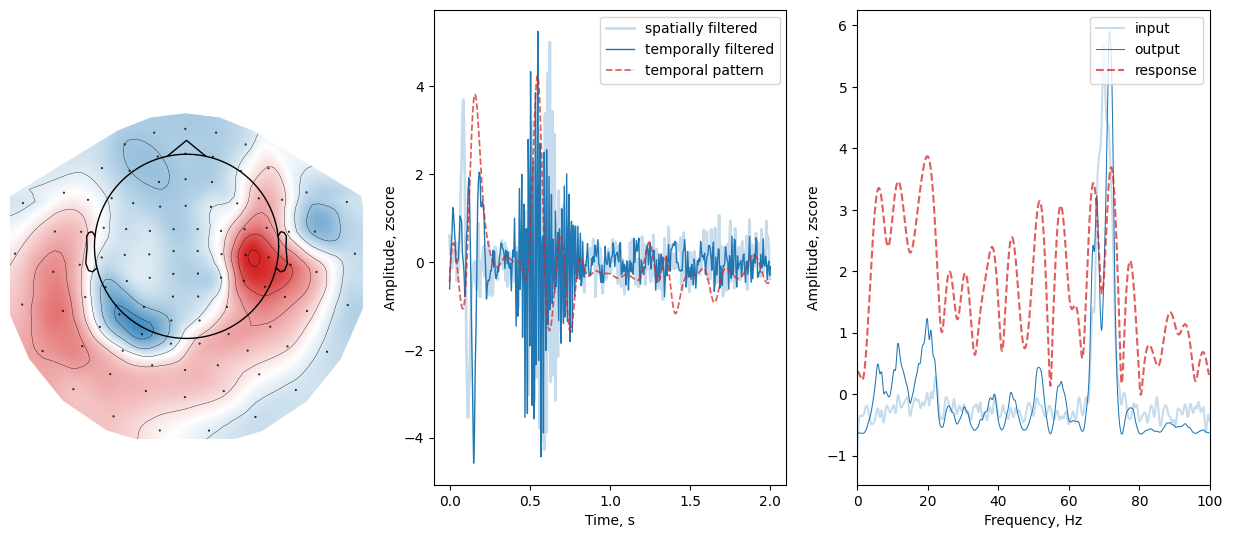

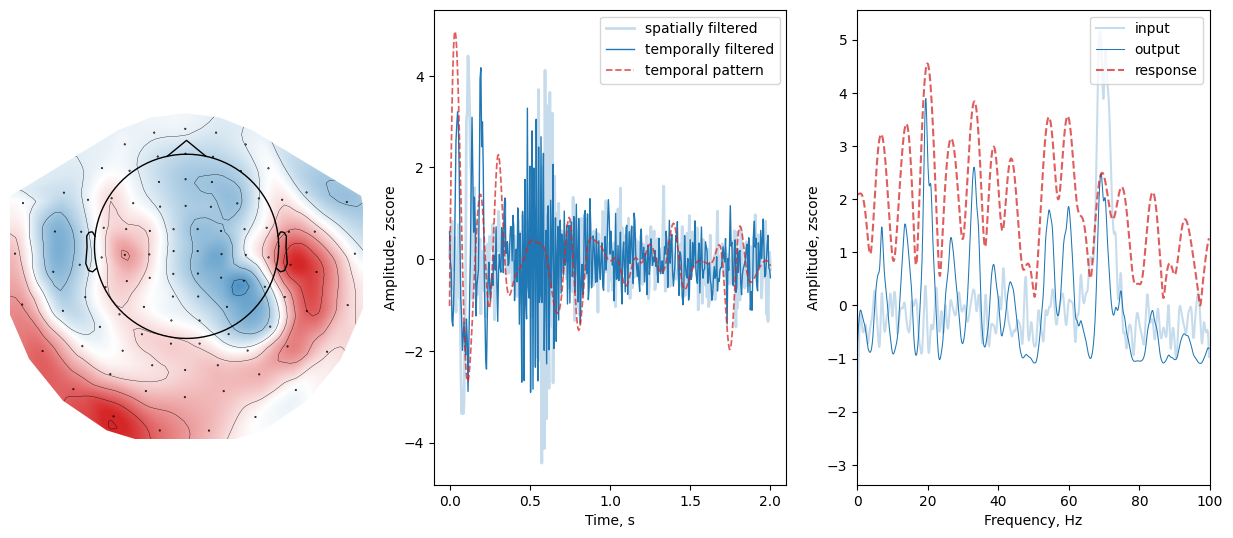

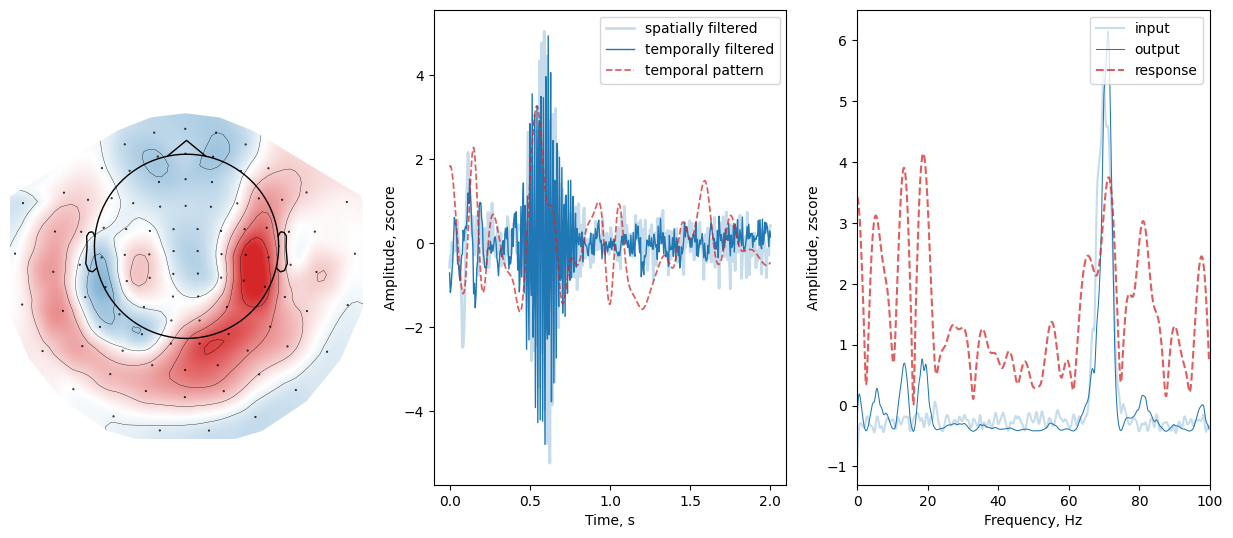

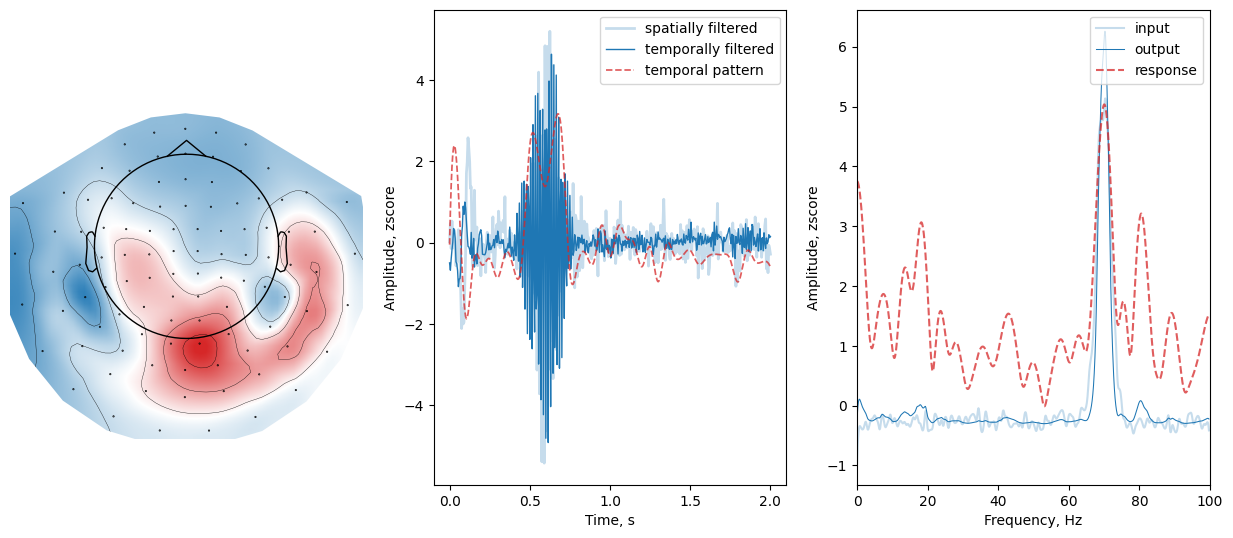

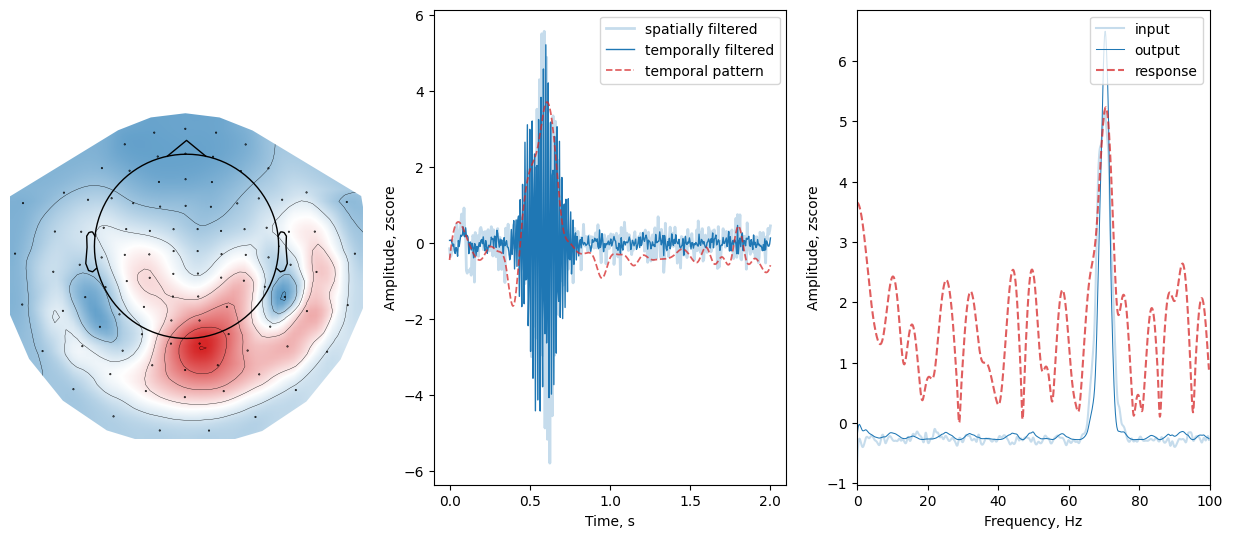

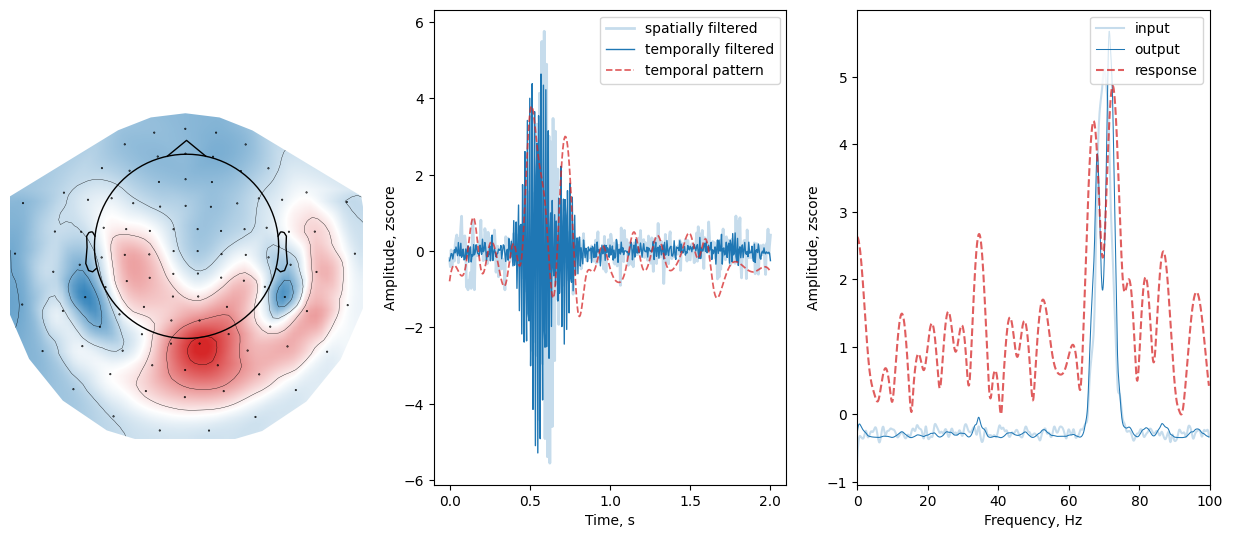

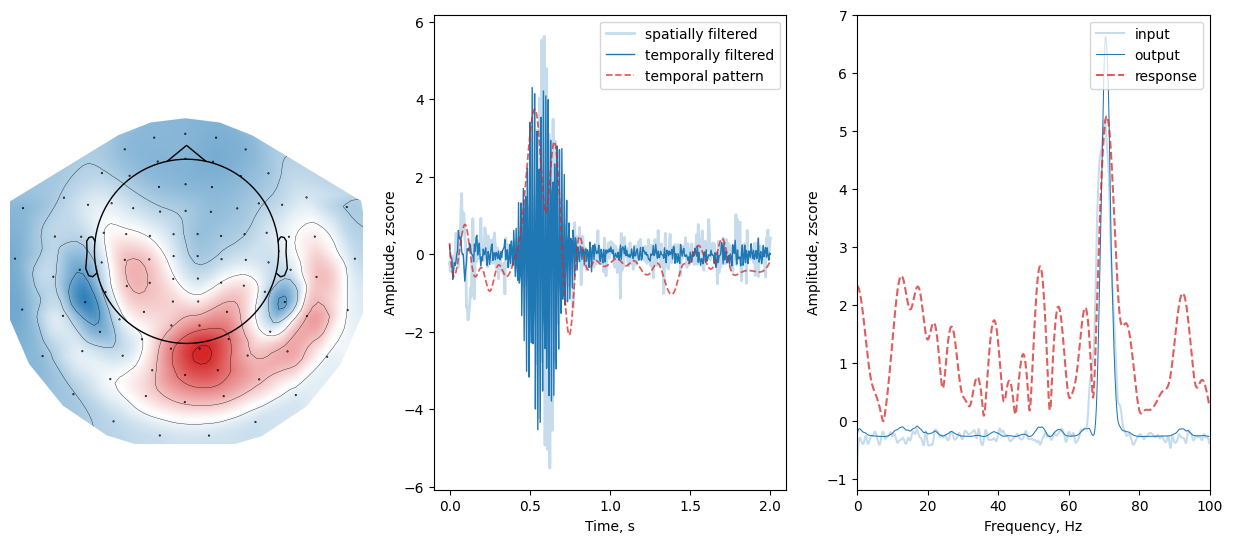

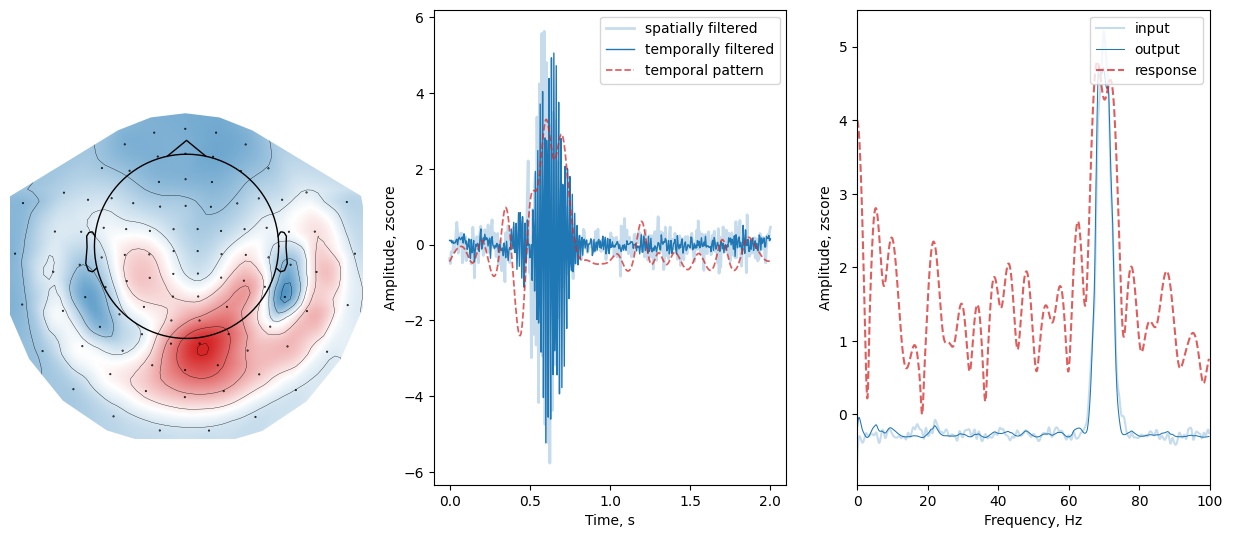

In [60]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNWInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

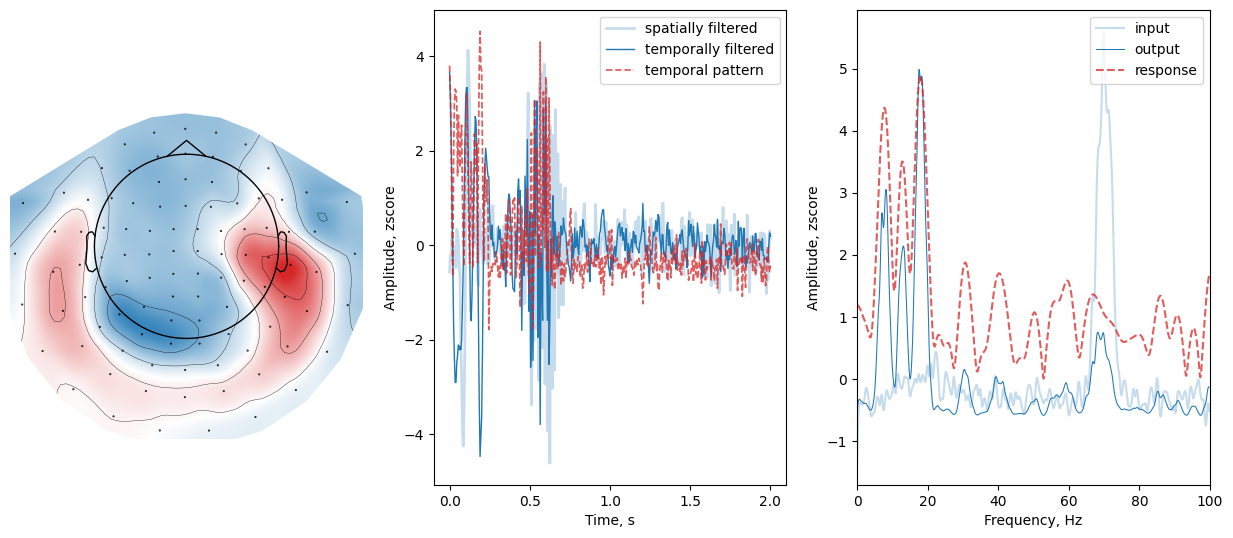

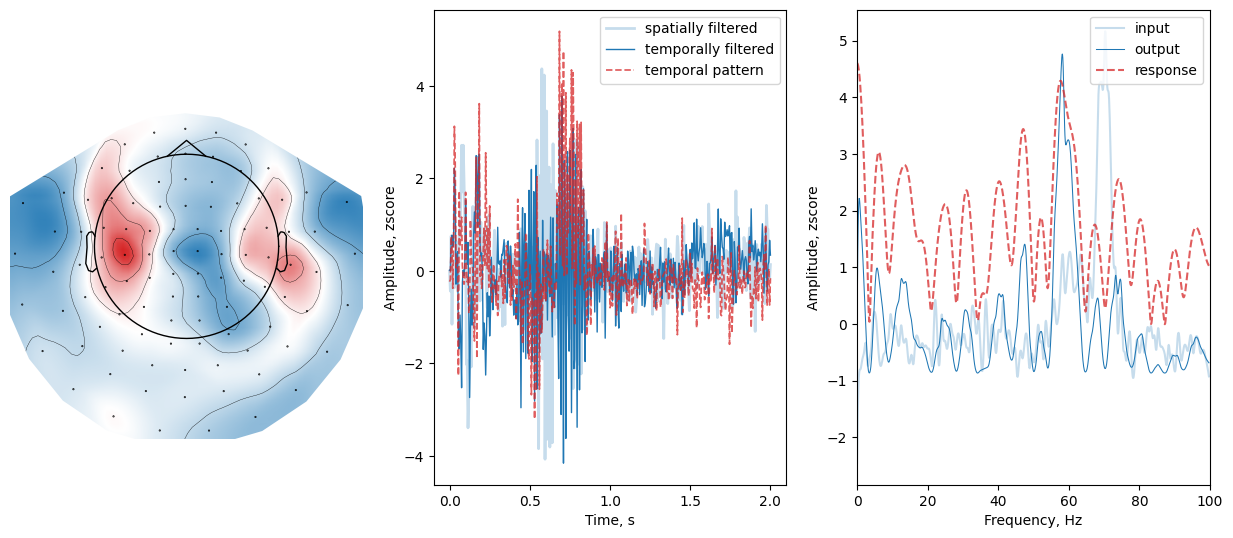

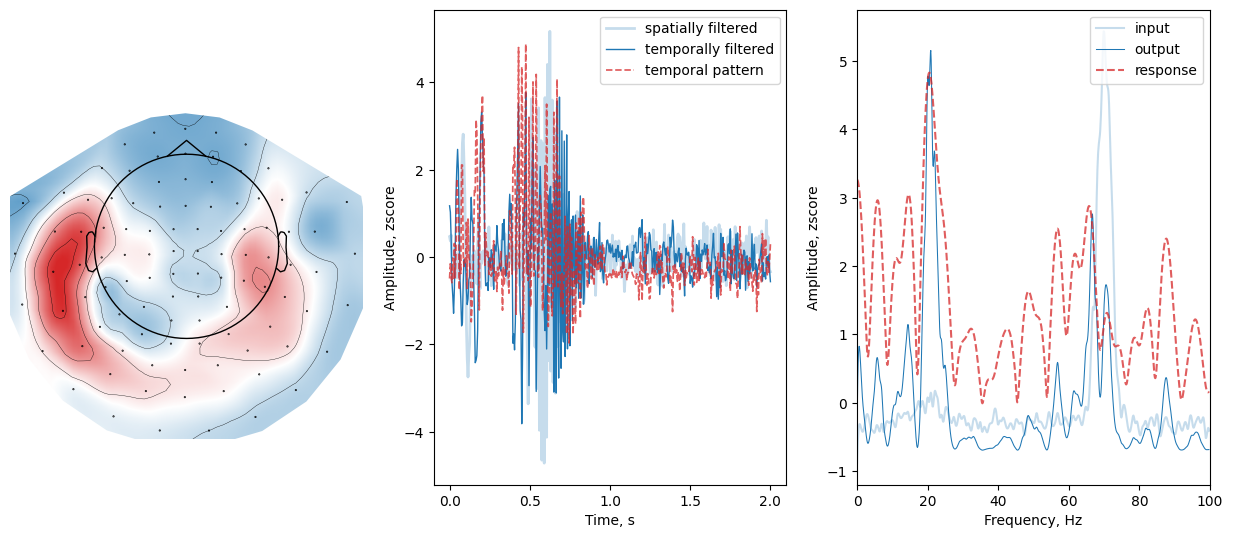

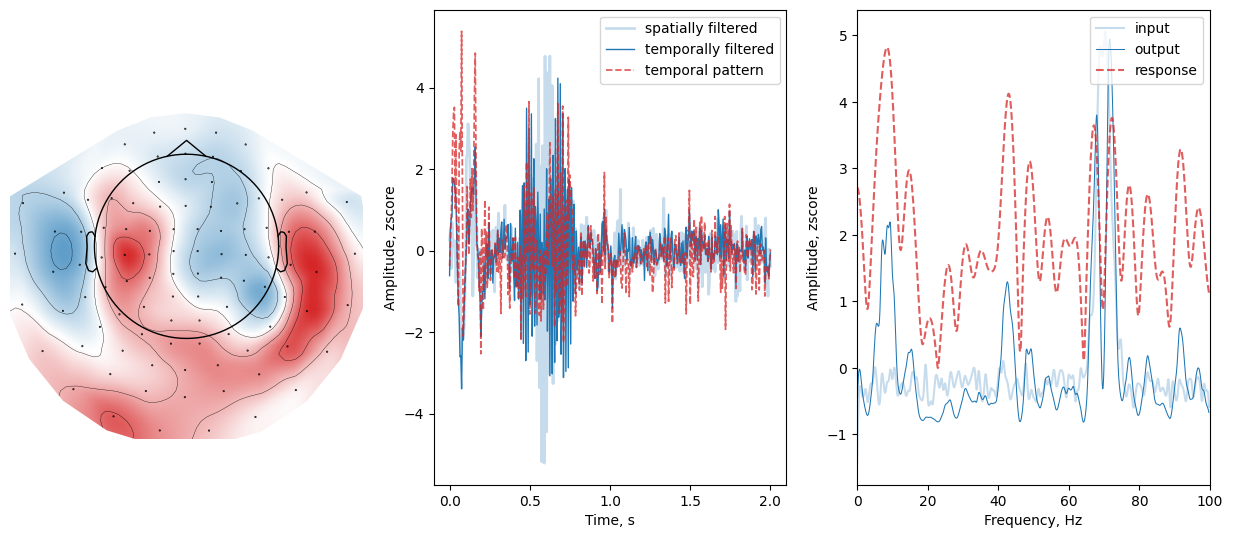

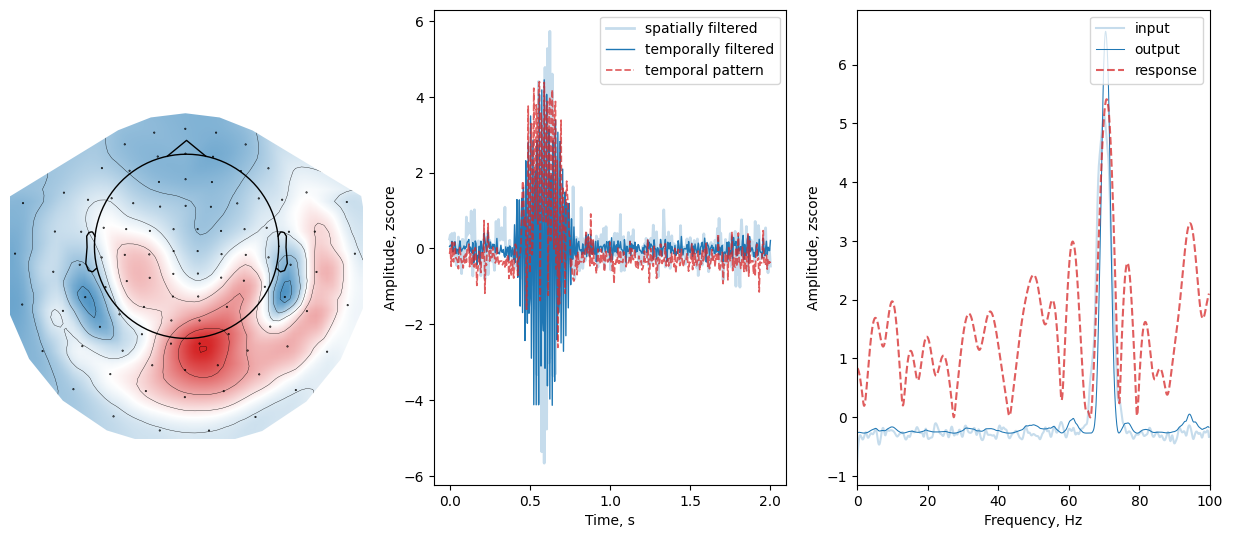

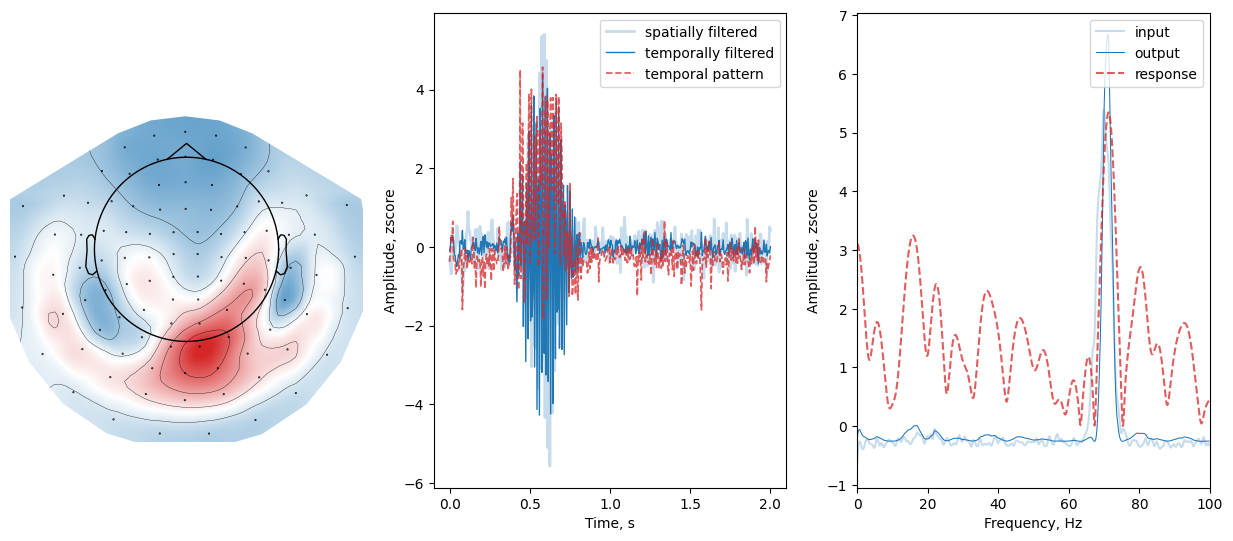

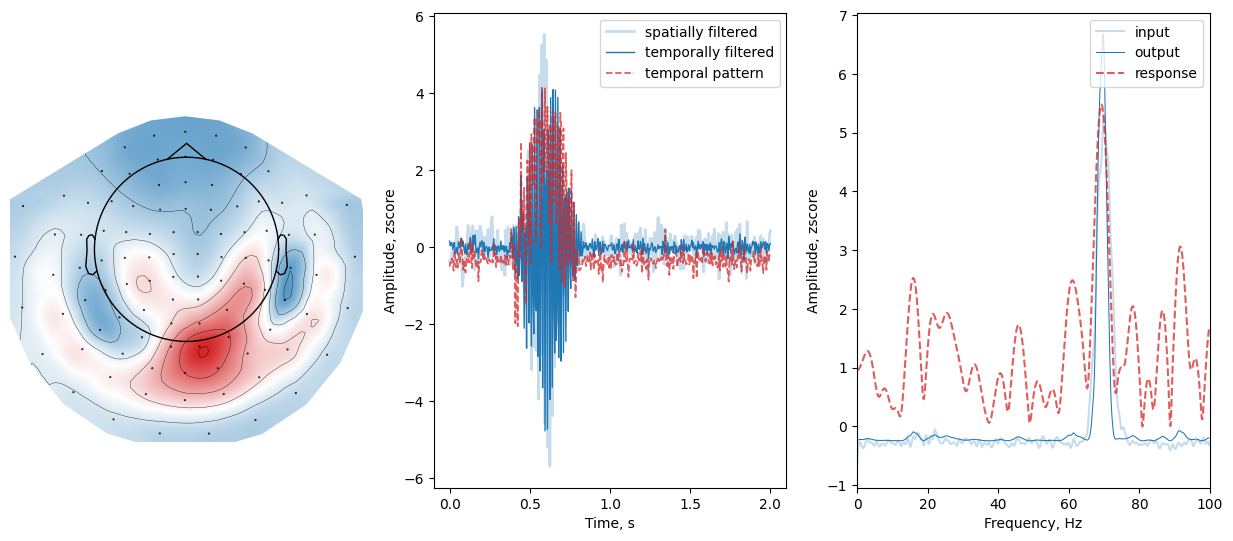

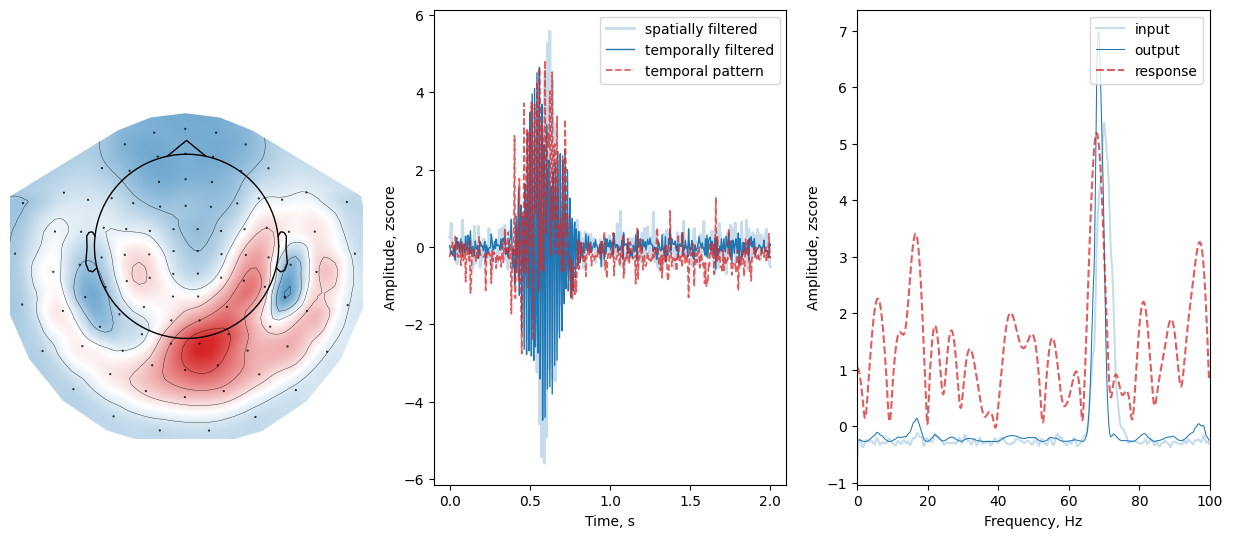

In [64]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNWInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()